# The Main Loop
This does the full cycle for active learning and aligning bags.

## Parameters

In [1]:
versionname = "ds_4 normprobs threshold"
original = False
al_strategy = "entropy"
load = False
from PUMILADmain.Create_DS.create_ds_4_EqualDistributions import gen_data

k = 30          # number of instances/bag
nbags = 10      # number of bags
bag_contfactor = .4 # number of contaminated bags
query_budget = 1 #61 # nbs*k# 30# 30*10 # TODO
restart = True   # Do you restart the normalizing flows or do you finetune?
smartguess = False

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from data import Data
from methods import MABMethod
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
import matplotlib
import sys
import warnings
sys.path.insert(1, '../')
from dataBag import DataBag
from rewardInfo import RewardInfo
from itertools import cycle
from alignflow_master.train_copyFullDataset import main
import os
import pathlib
from alignflow_master.dataReplacer import DataReplacer
current = pathlib.Path().parent.absolute()
p =  os.path.join(current, "seed.txt")
file = open(p)
seed = int(file.read())
file.close()
np.random.seed(seed)

## Construct dataset

In [3]:
bags, bags_labels, X_inst, y_inst = gen_data(k = k, nbags = nbags, bag_contfactor = bag_contfactor, seed = 1302)
# gen_data gives 3 dimensions.


# stick to 2 dimensions for now: (remove this later: TODO)
# AND NORMALIZE BETWEEN -1 AND 1 for each bag seperately!!!
X_inst = X_inst[:,:2]
originalBags = {}
i = 0
for k, v in bags.items():
    dummy = v[:,:2].copy()
    if not original:
        maxim = np.max(v[:,:2].copy(), axis = 0)
        minim = np.min(v[:,:2].copy(), axis = 0)
        dummy = 2*(dummy-minim)/(maxim-minim)-1
    originalBags[k] = dummy
    X_inst[i:i+len(dummy),:2] = dummy
    i += len(dummy)
if i != len(X_inst):
    raise Exception("Implementation Error: {}, {}, {}".format(i, len(dummy), len(X_inst)))
bags = originalBags
D = bags
bags = np.array(list(D.values()))

## Set up variables

In [4]:
originalBags = originalBags # The original bags, in dictionary format
bags = bags # The original bags, in list of lists format
dataBag = DataBag(bags, bags_labels, X_inst, y_inst) # The object that stores information about the labels and bag tensors.
rewardInfo = RewardInfo(len(bags_labels)) # The object that stores information about the process, for plotting purposes.
dataReplacer = DataReplacer(nbags).setInitData(originalBags) # The object that sets the input for the normalizing flows
alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = al_strategy) # The alba method
training_data = Data(nbags).set_domains_and_labels(originalBags)

## Plot the original dataset

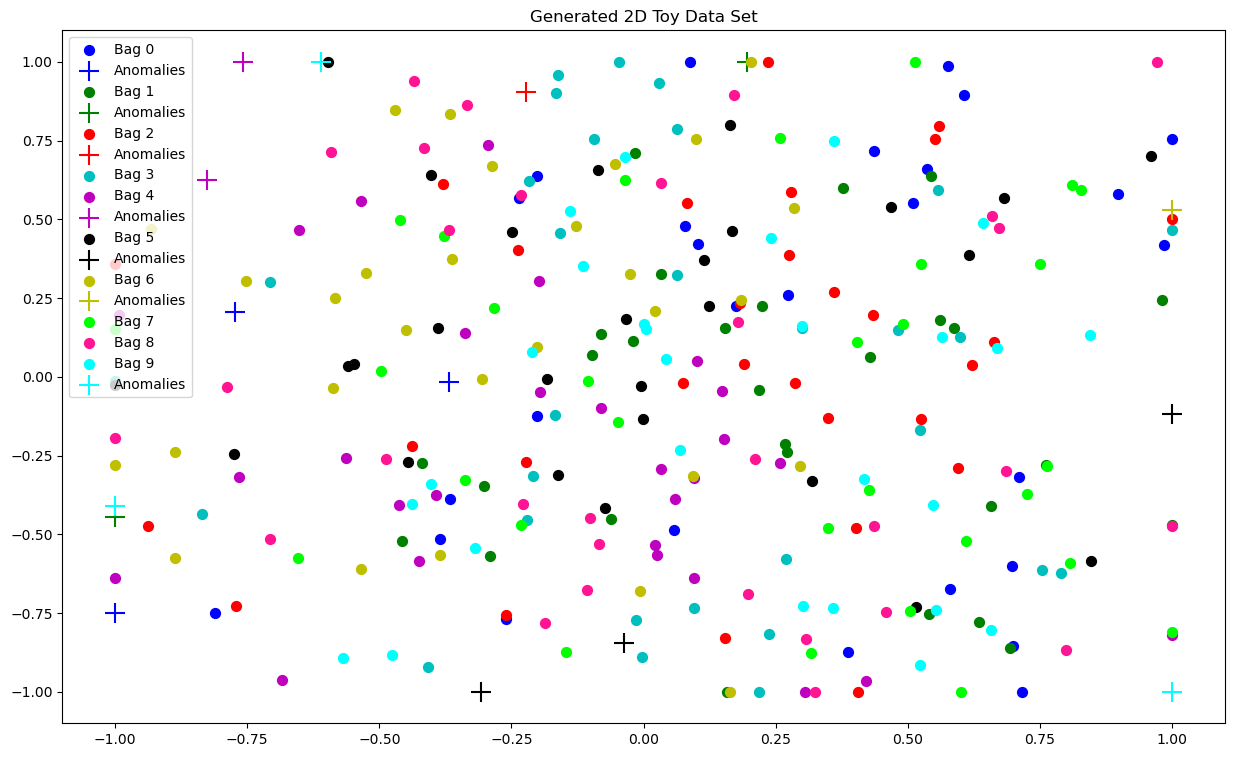

In [5]:
clrs = ['b','g','r','c','m','k','y', 'lime','deeppink','aqua','yellow','gray','darkorange','saddlebrown','salmon']
cycol = cycle(clrs)

fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (15,9) )

for bag in range(len(bags)):
    ## Extract the anomalies and the normals in the bag.
    anomalies = dataBag.getAnomalies(bag)
    normals = dataBag.getNormals(bag)
    
    c=next(cycol)
    if (len(normals)>0):
        ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label = "Bag "+str(bag))
    if (len(anomalies)>0):
        ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies")

plt.title('Generated 2D Toy Data Set')
plt.legend()
plt.savefig('img/original.png',bbox_inches='tight')
plt.show()
plt.close(fig)

## Some helper functions (TODO: check)

In [6]:
def getPrediction(alba: MABMethod, data: Data):
    probabilities = alba.predict(data, True)
    return probabilities

def noisyOr(labels):
    lst = np.zeros((len(labels.keys())))
    for bag in labels.keys():
        lbls = np.array(labels[bag])
        lbls = 1-lbls
        lst[bag] = 1-np.prod(lbls)
    return lst

def diff2dd(A, B):
    # https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [A.dtype]}
    C = np.setdiff1d(A.view(dtype), B.view(dtype))
    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def currentPrediction(alba: MABMethod, data: Data, bags: dict, newinstanceKey: int, instance, labeledPos = None, labeledNeg = None, t=0, weights = None):
    """
    t: iteration """

    cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 

    if weights == None:
        weights = {}
        k = 0
        for bag in bags:
            weights[k] = np.ones((bag.shape[0]))
            k +=1


    for bag in range(len(bags)):
        domain = bags[bag]
        pos = np.asarray(labeledPos[bag])
        neg = np.asarray(labeledNeg[bag])
        domain = diff2dd(domain, pos)
        domain = diff2dd(domain, neg)
        c = next(cycol)

        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=c)
        
        if (len(pos)>0):
            ax.scatter(pos[:,0], pos[:,1], marker = '+', c=c)
        if (len(neg)>0):
            ax.scatter(neg[:,0], neg[:,1], marker = '_', c=c)


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('img/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)



    probabilities = getPrediction(alba, data)

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

    nrows = 3
    ncols = 4
    fig, axs = plt.subplots( nrows=nrows, ncols=ncols ,figsize=(16,9)) 
    final_ax = axs[-1,-1]
   
    for bag in range(len(bags)):
        ax = axs[bag//ncols, bag-ncols*(bag//ncols)]
        domain = bags[bag]
        anomalies = []
        normals = []
        prsa = []
        prsn = []
        
        for idx in range(len(domain)):
            if dataBag.isAnomaly(bag, idx):
                anomalies.append(domain[idx,:])
                prsa.append(probabilities[bag][idx])
            else:
                normals.append(domain[idx,:])
                prsn.append(probabilities[bag][idx])

        normals = np.asarray(normals)
        anomalies = np.asarray(anomalies)


        ax.scatter(normals[:,0], normals[:,1], norm = norm, c =prsn, s = 100,  edgecolors='k', cmap = 'coolwarm')
        final_ax.scatter(normals[:,0], normals[:,1], norm = norm, c =prsn, s = 100,  edgecolors='k', cmap = 'coolwarm')
        if len(anomalies)>0:
            ax.scatter(anomalies[:,0], anomalies[:,1], norm = norm, c =prsa, s = 100, edgecolors='k', marker = "+",  cmap = 'coolwarm')
            final_ax.scatter(anomalies[:,0], anomalies[:,1], norm = norm, c =prsa, s = 100, edgecolors='k', marker = "+",  cmap = 'coolwarm')
        if (bag == newinstanceKey):
            ax.scatter(instance[0], instance[1], c='lime')
            final_ax.scatter(instance[0], instance[1], c='lime')


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('colorimg/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)



    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 
    domain = np.zeros((0,2))
    prs = np.zeros((0))
    w = np.zeros((0))
    fl1 = True
    fl2 = True
    for bag in range(len(bags)):
        domain = np.concatenate((domain,bags[bag]))
        prs = np.concatenate((prs, probabilities[bag]))
        w = np.concatenate((w, weights[bag]))

        anomalies = []
        normals = []
        wn = []
        wa = []
        prsa = []
        prsn = []

        domain = bags[bag]
        for idx in range(len(domain)):
            if dataBag.isAnomaly(bag, idx):
                anomalies.append(domain[idx])
                prsa.append(probabilities[bag][idx])
                wa.append(weights[bag][idx])
            else:
                normals.append(domain[idx])
                prsn.append(probabilities[bag][idx])
                wn.append(weights[bag][idx])

        normals = np.asarray(normals)
        anomalies = np.asarray(anomalies)
        wn = np.asarray(wn)
        wa = np.asarray(wa)
        if (len(normals)>0):
            if fl1:
                z = ax.scatter(normals[:,0], normals[:,1], marker='o', norm=norm, c=prsn, cmap="coolwarm", s=250-200*wn, edgecolors='k', label = "Real normal")#, c= 'b')
                fl1 = False
            else:
                z = ax.scatter(normals[:,0], normals[:,1], marker='o', norm=norm, c=prsn, cmap="coolwarm", s=250-200*wn, edgecolors='k')#, c= 'b')
        if (len(anomalies)>0):
            if fl2:
                ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', norm=norm, c=prsa, cmap="coolwarm", s=250-200*wa, edgecolors='k', label = "Real anomaly")#,c= 'b') 
                fl2 = False
            else:
                ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', norm=norm, c=prsa, cmap="coolwarm", s=250-200*wa, edgecolors='k')#,c= 'b')  
    
    ax.scatter(instance[0], instance[1],c='lime',label = "Selected instance",s=400, edgecolors='k')


    scoreroc = roc_auc_score(np.rint(y_inst), prs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(y_inst), prs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scorepr = auc(recall, precision)
    bagprobs = noisyOr(probabilities)
    scorerocBag = roc_auc_score(np.rint(bags_labels), bagprobs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(bags_labels), bagprobs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scoreprBag = auc(recall, precision)

    plt.title('Iteration '+str(t).zfill(3), fontsize = 16)
    rewardInfo.updateAuc("roc", scoreroc)
    rewardInfo.updateAuc("pr", scorepr)
    rewardInfo.updateAuc("rocbag", scorerocBag)
    rewardInfo.updateAuc("prbag", scoreprBag)

    
    textstr = "ROC AUC = {:.10f}\nPR AUC = {:.10f}\nROC AUC BAG= {:.10f}\nPR AUC BAG= {:.10f}".format(scoreroc, scorepr, scorerocBag, scoreprBag)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props)

    
    cbar = fig.colorbar(z,ax= ax, label ="higher score = more positive")
    tick_font_size = 14
    cbar.ax.tick_params(labelsize=tick_font_size)
    plt.rcParams.update({'font.size': 14})
    ax.legend(loc = "lower right", fontsize= 14)

    fig.savefig('colorimg2/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)

    return probabilities


def edgen(probs):
    return probs
    N = 20

    idxs = probs>.5
    print(idxs)
    print(np.invert(idxs))
    print(idxs.shape)
    a = np.invert(idxs)
    probs[a] = np.power(2*probs[a],2*N)/2
    probs[idxs] = 1-np.power(2*(probs[idxs]-1),2*N)/2
    return probs


def predictBegin(test_data):
        import transfer_learning_seperateArms as tl
        clsf = tl.get_transfer_classifier(
                "none", "anomaly"
            )  
        clsf.apply_transfer(test_data)
        clsf.fit_all(test_data, ignore_unchanged=False)
        probs = clsf.predict(test_data, True)

        
        minim, maxim = np.Inf, -np.Inf
        for k,v in probs.items():
            m = np.min(v) 
            if m < minim:
                 minim = m
            m = np.max(v)
            if m > maxim:
                 maxim = m
                 
        predictions = {}
        allprobs = np.zeros((0))
        for k,v in probs.items():
            predictions[k] = (v-minim)/(maxim-minim)
            allprobs = np.concatenate((allprobs, predictions[k]))

        CONT_FACTOR = .1
        LENGTH = np.shape(allprobs)[0]
        thr_idx = LENGTH - int(np.ceil(LENGTH*CONT_FACTOR))
        idxs = np.argsort(allprobs)
        threshold = np.sum(allprobs[idxs[thr_idx-1:thr_idx+1]])/2
        
        summm = 0
        newpredictions = {}
        for k,v in predictions.items():
            probabs = v/threshold
            newpredictions[k] = edgen(1-np.power(2, -probabs))
            summm += np.sum(newpredictions[k]>=.5)

        return newpredictions


In [7]:
if (False and original):
    t = 0  
    labeledPos = {}
    labeledNeg = {}
    for bag in range(len(bags)):
        labeledNeg[bag] = []
        labeledPos[bag] = []
    performance = []

    import warnings
    warnings.filterwarnings('ignore')

    for t in range(query_budget):
        queries = alba.fit_query(training_data, True)

        #!!!!!!!
        key,idx = queries[0]
        i = 0
        while dataBag.isLabeled(key,idx):
            i+=1
            key, idx = queries[i]
            
        rewardInfo.chooseArm(key)
        key,idx = queries[i]
        instance = training_data.get_domain(key)[idx]
        lbl = dataBag.getLabel(key, idx)
        training_data.set_new_label(key, idx, lbl)
        training_data.set_last_labeled(key,idx)
        dataBag.label(key,idx)
        if (lbl == 1):
            labeledPos[key].append(instance.tolist())
        else:
            labeledNeg[key].append(instance.tolist())

        currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, t)
        
        #performance.append(dataBag.measureAccuracy(predictions))
        print(t)

    ## window = 10!!!

In [8]:
if False and original:
    import cv2
    import os

    image_folder = 'img'
    video_name = 'videoOriginal.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg'
    video_name = 'videocolorimgOriginal.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

    image_folder = 'colorimg2'
    video_name = 'videocolorimg2Original.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

In [13]:
if True or not original:
    ## Initialize object variables
    training_data = Data(nbags)
    training_data.set_domains_and_labels(originalBags)
    labeledPos = {}
    labeledNeg = {}
    for bag in range(nbags):
        labeledNeg[bag] = []
        labeledPos[bag] = []
    alignedBags = originalBags.copy()
    if smartguess:
        dataReplacer.setWeights(predictBegin(training_data))
    weights = dataReplacer.getWeights()

    ## THE ULTIMATE LOOP
    for iteration in range(query_budget):
            
        print("=================")
        print("ITERATION", iteration)
        print("=================")
        
        # Set the input for the normalizing flows.
        if not original:
            dataReplacer.setData(originalBags)
            if restart:
                try:
                    os.remove(os.path.join(pathlib.Path().parent.resolve(), "alignflow_master", "ckpts", "normalaligner", "best.pth.tar"))
                except Exception as exc:
                    print("No model found to remove")

            # Align the instances
            aligner = main(dataReplacer, y_inst, load)

            # Get the aligned data
            alignedData = dataReplacer.getLatent()
            alignedBags = np.array(list(alignedData.values()))
            weights = dataReplacer.getWeights()

            # Change the data used in ALBA to the aligned data
            for k, v in alignedData.items():
                training_data.reset_domain(k, v)

        # Select an instance using ALBA
        warnings.filterwarnings('ignore')
        queries = alba.fit_query(training_data, True)
        i = 0
        key,idx = queries[i]
        while dataBag.isLabeled(key,idx):
            i+=1
            key, idx = queries[i]
        instance = training_data.get_domain(key)[idx]

        ## Query the instance to the oracle (= get the label)
        lbl = dataBag.getLabel(key, idx)
        training_data.set_new_label(key, idx, lbl)
        training_data.set_last_labeled(key,idx)
        dataBag.label(key,idx)
                    
        # Store some information/bookkeeping to use for plotting later on
        rewardInfo.chooseArm(key)
        if (lbl == 1):
            labeledPos[key].append(instance.tolist())
        else:
            labeledNeg[key].append(instance.tolist())
        #performance.append(dataBag.measureAccuracy(predictions))

        # Plot the result of this iteration
        ws = currentPrediction(alba, training_data, alignedBags, key, instance, labeledPos,labeledNeg, iteration, weights = weights)

        if not original:
            dataReplacer.setWeights(ws)
            


ITERATION 0
Starting new model
False
START 1712838485.295392
[start of epoch 1]


KeyboardInterrupt: 

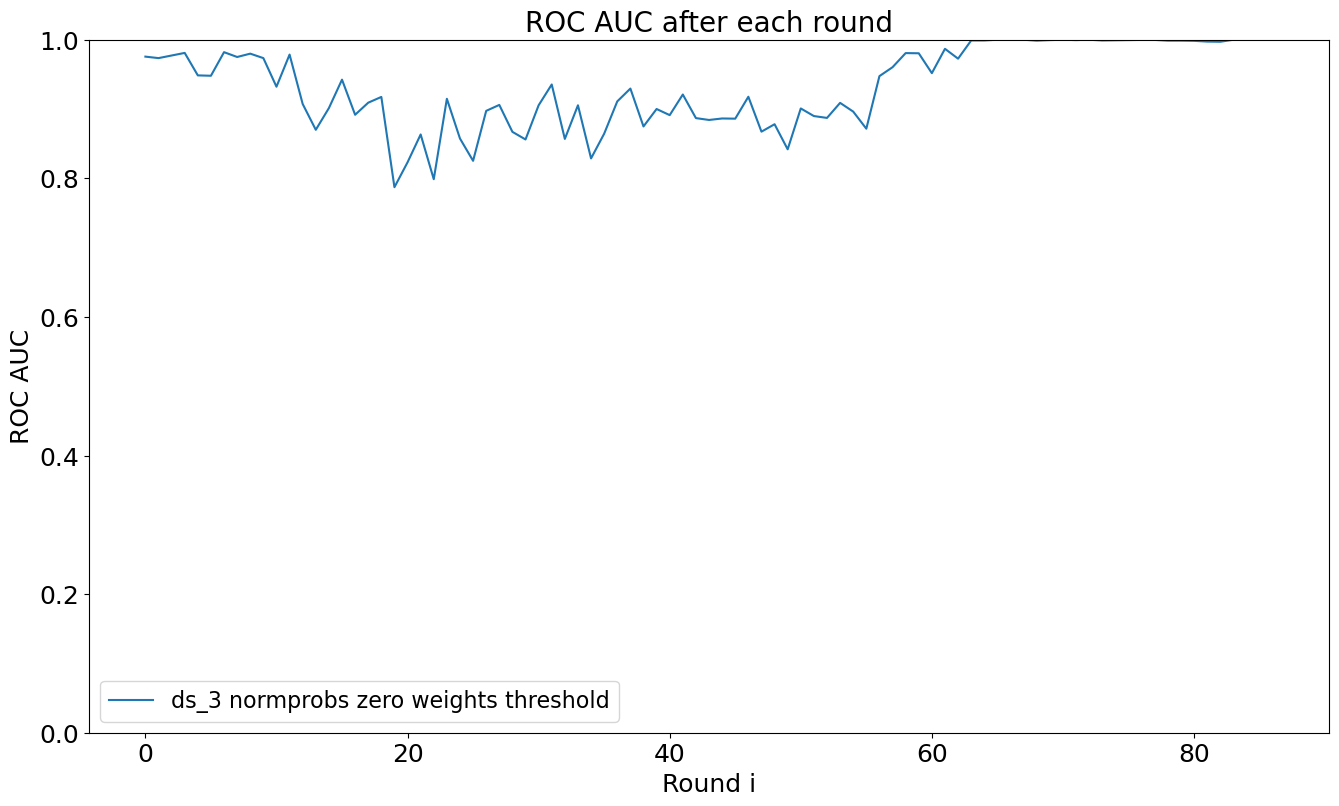

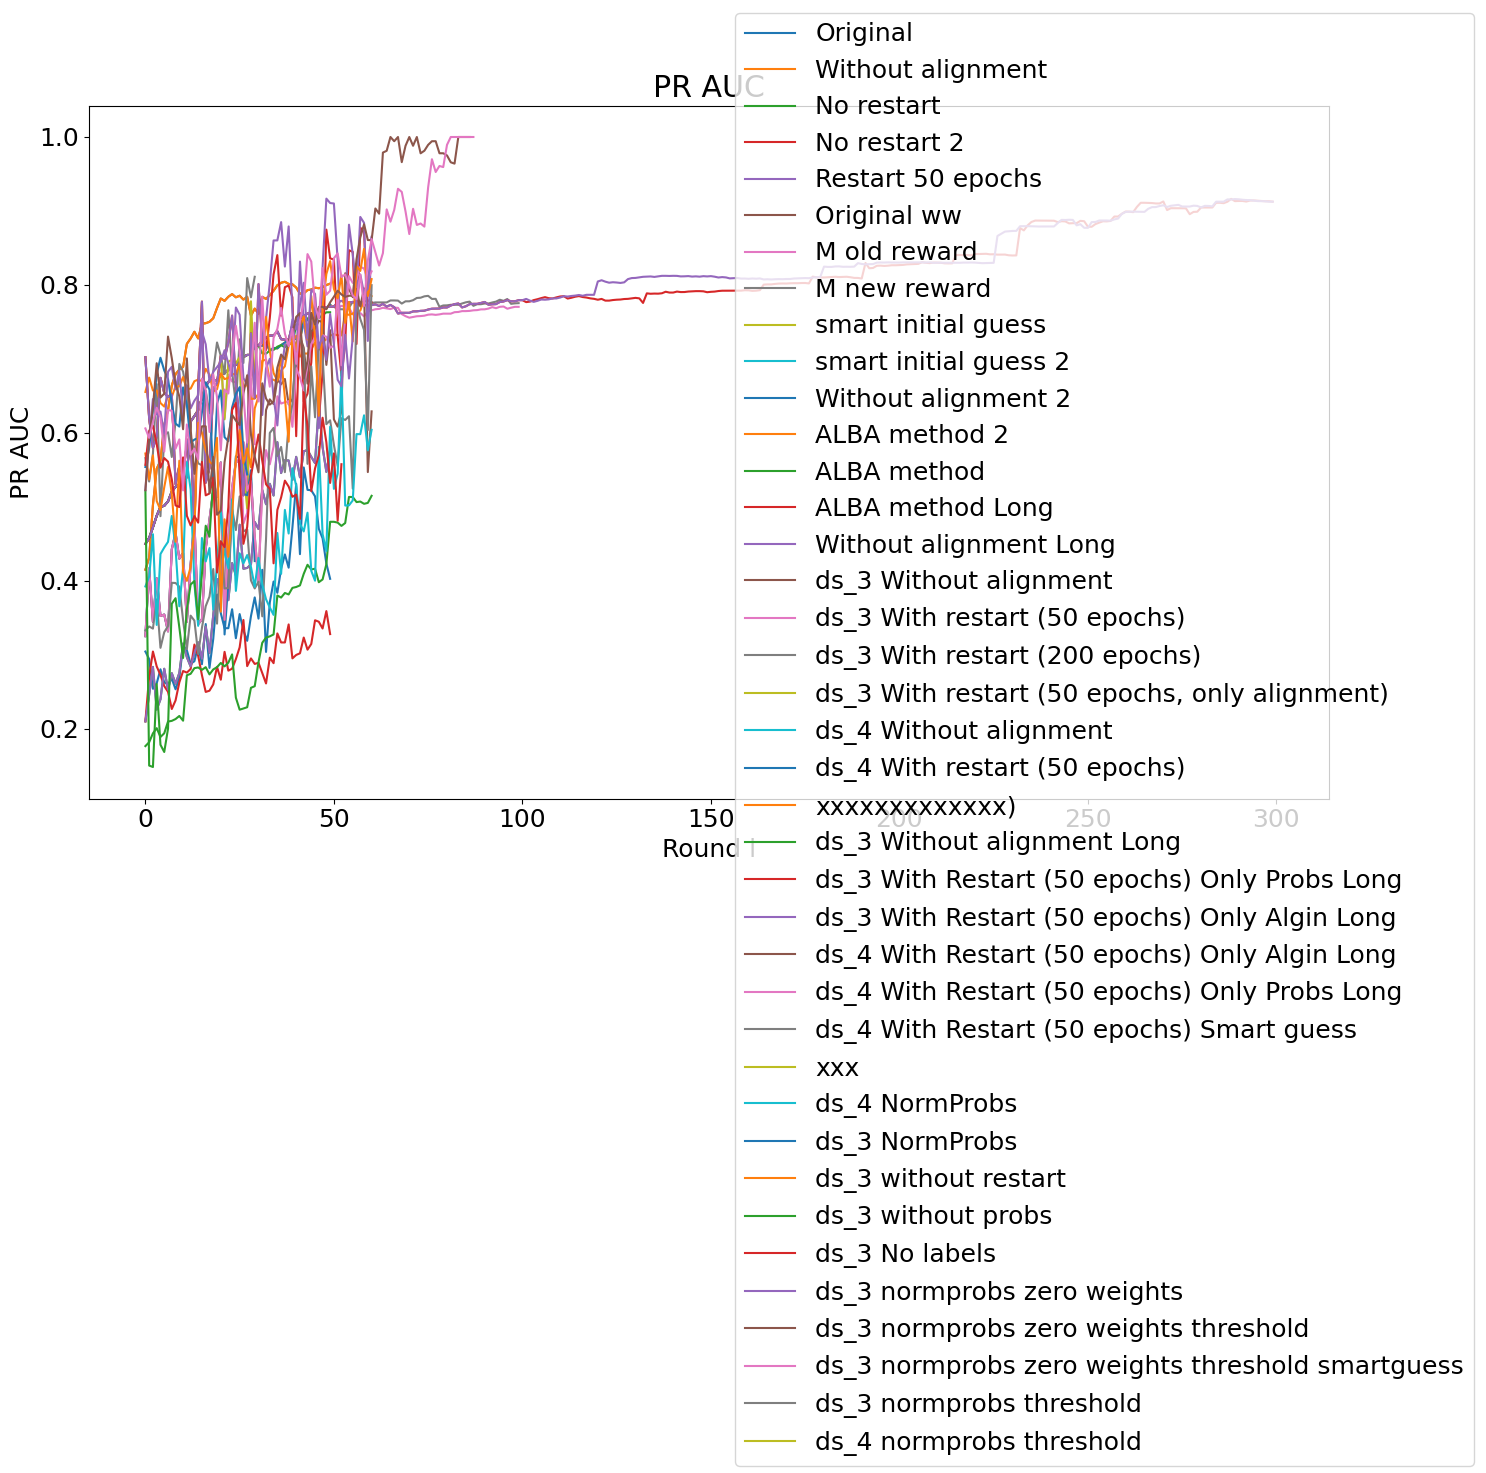

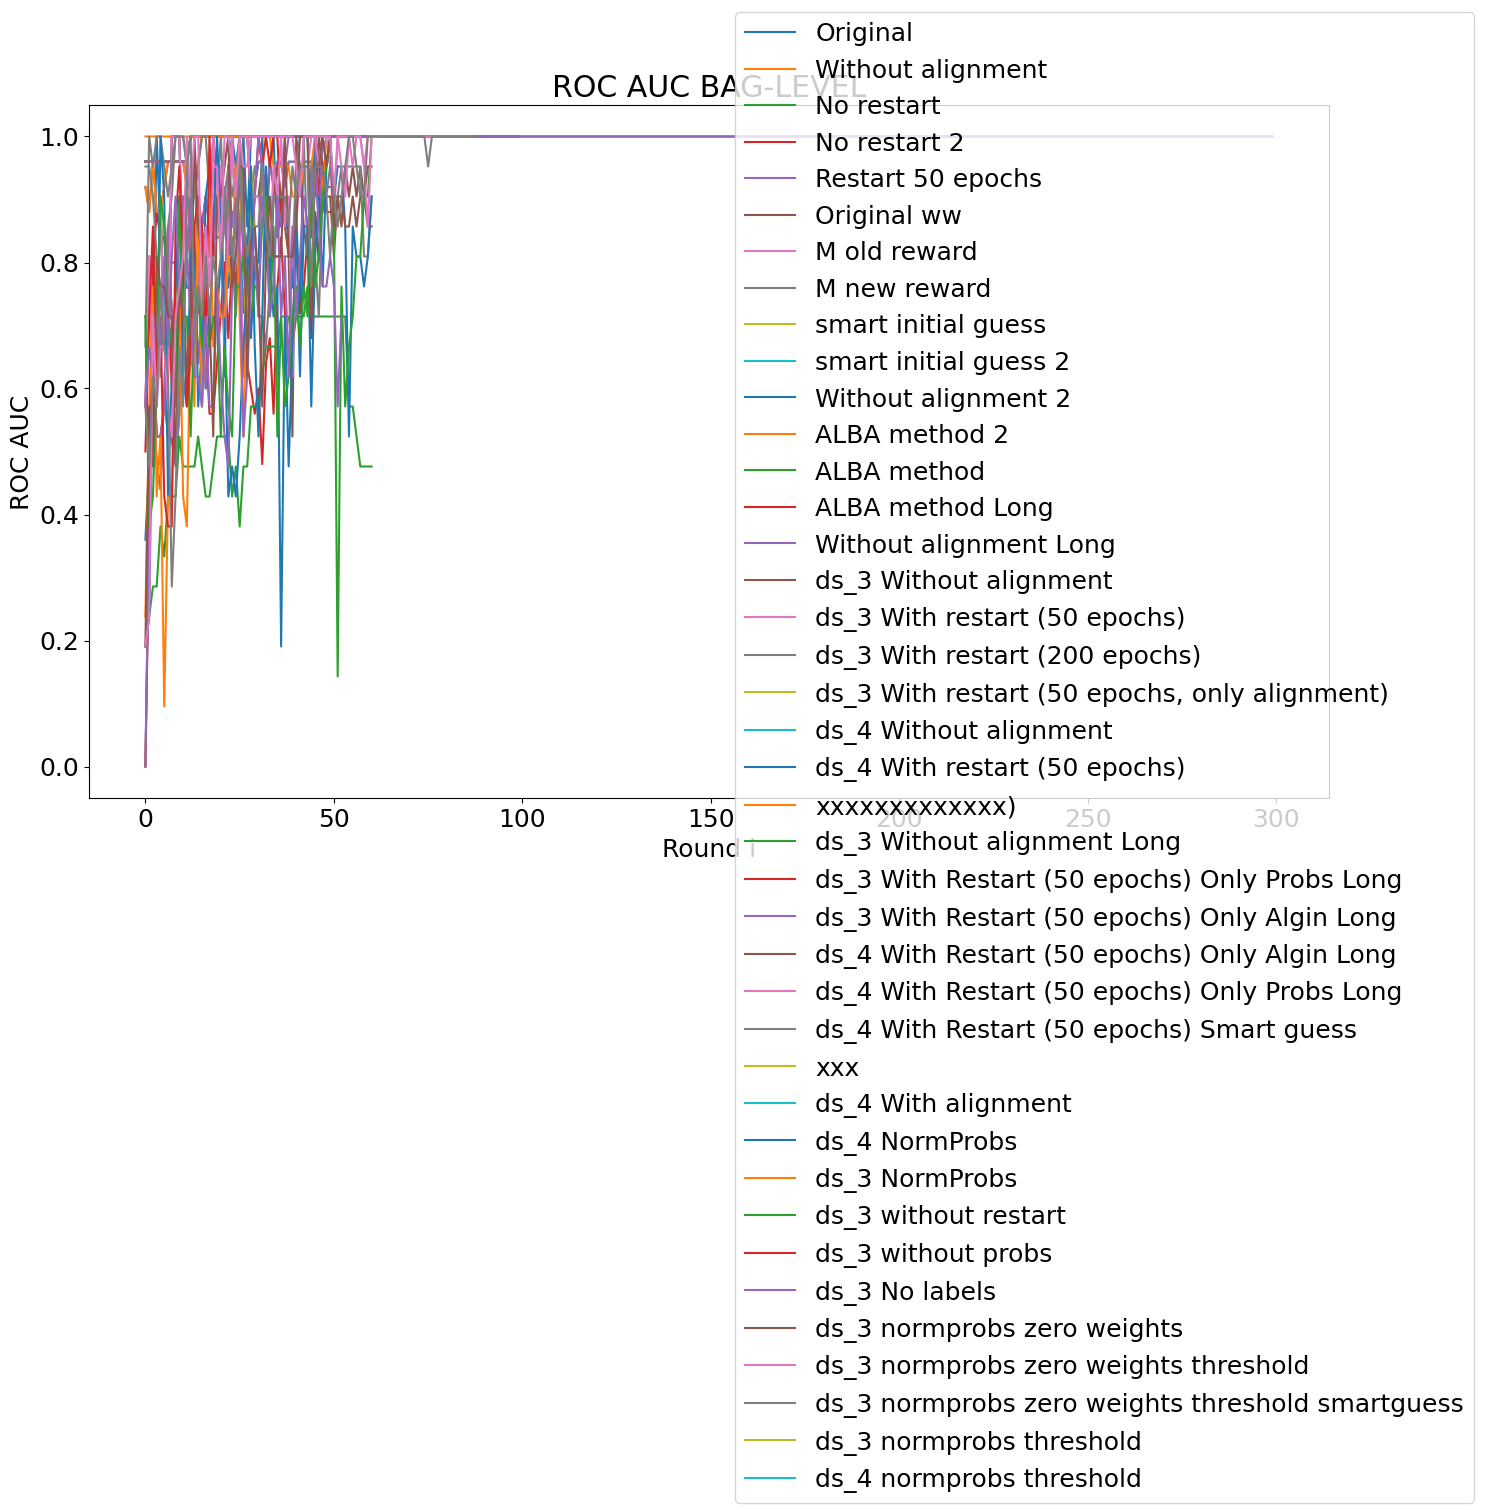

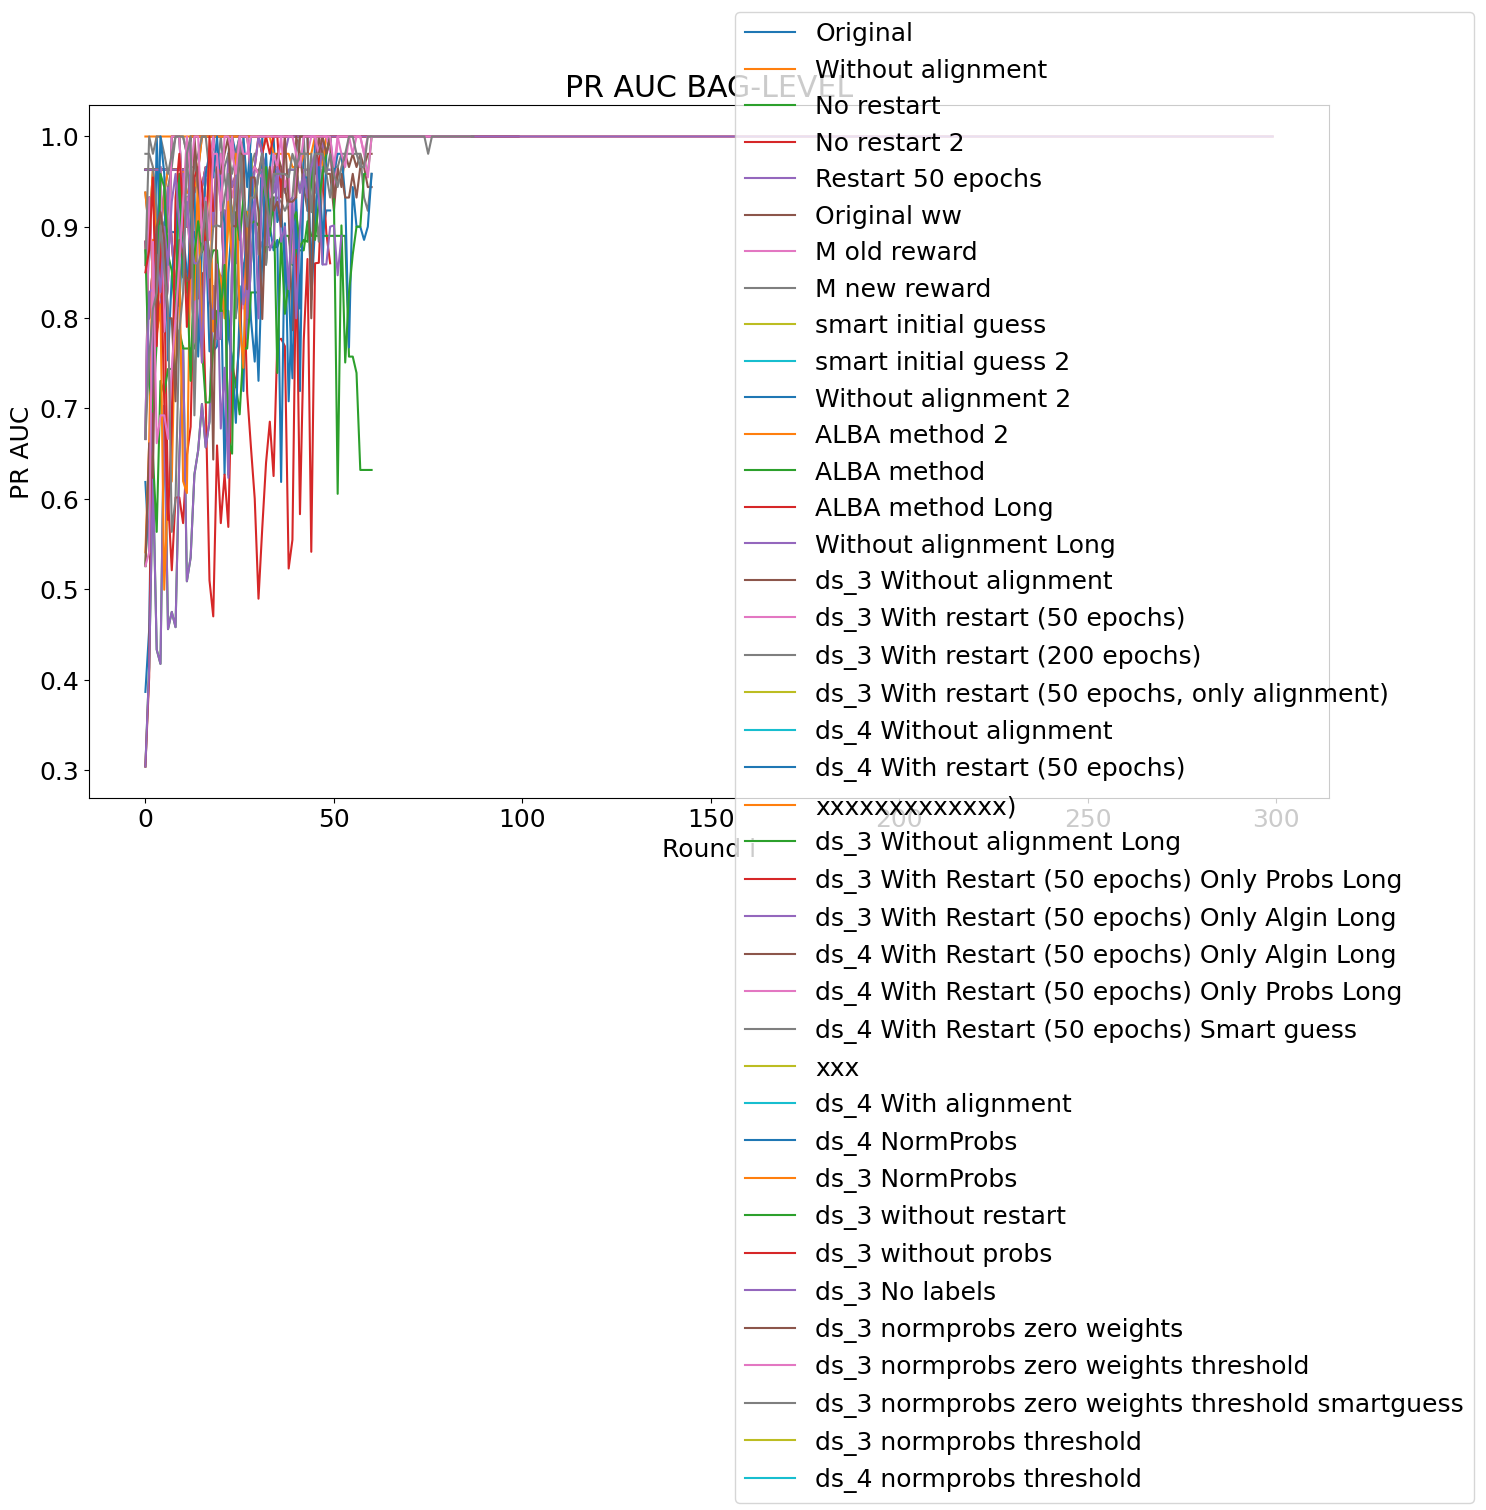

In [18]:

fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["roc"]
import csv
with open('auc_roc.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = False
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True or "X" in line[0]:
        if "aligned-random" == line[0]:
            line[0] = "aligned-random-continue"
        if "onepoch" in line[0]:
            x = line[0].split("onepoch")
            line[0] = "continue".join(x)
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC after each round', fontsize=20)
plt.ylabel('ROC AUC',fontsize=18)
plt.xlabel('Round i',fontsize=18)
plt.legend(fontsize = 16)
plt.ylim([0,1])
fig.savefig('img/ROC AUC.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["pr"]
import csv
with open('auc_pr.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True and not "push" in line[0]:
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
fig.legend()
plt.show()
fig.savefig('img/PR AUC.png',bbox_inches='tight')
plt.close(fig)


## BAGLEVEL

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["rocbag"]
import csv
with open('auc_roc_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True and not "push" in line[0]:
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC BAG-LEVEL')
plt.ylabel('ROC AUC')
plt.xlabel('Round i')
fig.savefig('img/ROC AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["prbag"]
import csv
with open('auc_pr_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if "random" in line[0] or True and not "push" in line[0]:
        ax.plot([float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC BAG-LEVEL')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
fig.savefig('img/PR AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

In [ ]:
print(rewardInfo.getIterationEndRoundRobin())

-1
